In [0]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt


In [173]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [174]:
file_path = "/content/drive/My Drive/collab/siraj/week2/GOOG.csv"
df = pd.read_csv(file_path)
df.set_index('Date', inplace=True)
df.index = pd.to_datetime(df.index)
df


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-09-14,625.700012,625.859985,619.429993,623.239990,623.239990,1702300
2015-09-15,626.700012,638.700012,623.780029,635.140015,635.140015,2084400
2015-09-16,635.469971,637.950012,632.320007,635.979980,635.979980,1286500
2015-09-17,637.789978,650.900024,635.020020,642.900024,642.900024,2274700
2015-09-18,636.789978,640.000000,627.020020,629.250000,629.250000,5133400
2015-09-21,634.400024,636.489990,625.940002,635.440002,635.440002,1788500
2015-09-22,627.000000,627.549988,615.429993,622.690002,622.690002,2562900
2015-09-23,622.049988,628.929993,620.000000,622.359985,622.359985,1470900
2015-09-24,616.640015,627.320007,612.400024,625.799988,625.799988,2240100


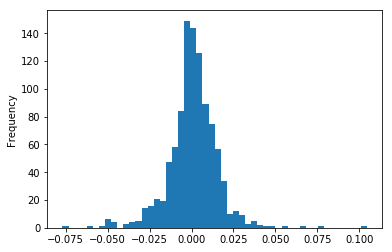

In [175]:
df['Adj Close'].pct_change().plot.hist(bins=50)
plt.show()


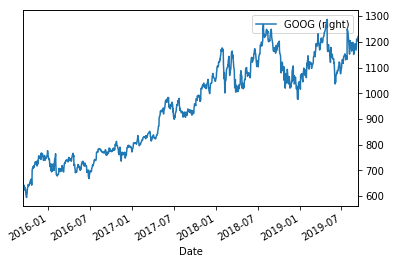

In [176]:
df['Adj Close'].plot(label='GOOG',  legend=True, secondary_y=True)
plt.show()



In [0]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.svm import SVR


In [178]:
df_cleaned = df.copy()
df_cleaned['Average'] = (df['Open'] + df['Close'] + df['High'] + df['Low']) / 4
df_cleaned.columns


Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Average'], dtype='object')

In [179]:
forcasting = 30
df_cleaned['Future Close'] = df[['Adj Close']].shift(-forcasting)
corr = df_cleaned[['Average', 'Future Close']].corr()
corr

,Average,Future Close
Average,1.00000,0.93766
Future Close,0.93766,1.00000


In [0]:
columns_drop =['Future Close','Open','Low','High','Close','Adj Close','Volume']
from sklearn import preprocessing
df_cleaned.dropna(inplace=True)
X=df_cleaned.drop(columns_drop,axis=1)
X.tail()
y=df_cleaned['Future Close'] 


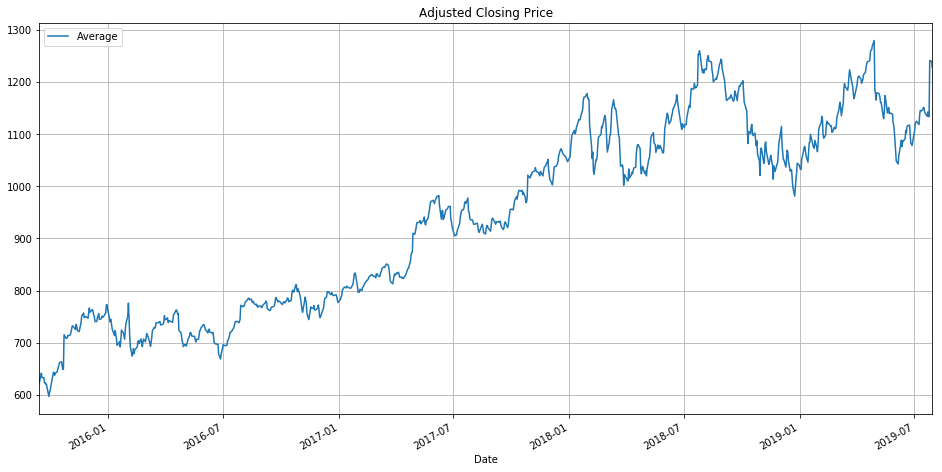

In [181]:
# plt.scatter(df_cleaned['Average'], df_cleaned['Future Close'])
X.plot(label='GOOG', figsize=(16,8), title='Adjusted Closing Price', grid=True)

In [0]:
# X=preprocessing.scale(X)


In [0]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3)

In [183]:
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
svr_rbf.fit(X_train, y_train)
svr_confidence = svr_rbf.score(X_test, y_test)
print("svr confidence: ", svr_confidence * 100,'%')

svr confidence:  84.34011019829383 %


In [184]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)   ##Train the model
lr_confidence = lr.score(X_test, y_test)
print("lr confidence: ", lr_confidence * 100,'%')

lr confidence:  86.8920250552222 %


In [185]:
from sklearn.ensemble import RandomForestRegressor

reg=RandomForestRegressor(n_estimators=200,random_state=101)
reg.fit(X_train,y_train)
reg_confidence = reg.score(X_test, y_test)
print("Reg confidence: ", reg_confidence * 100,'%')

Reg confidence:  88.57264117469575 %


In [186]:
preds = svr_rbf.predict(X_test)
print("The prediction(SVR) is:",preds[1],". The real value is:" ,y_test[1])

The prediction(SVR) is: 1187.2939669128136 . The real value is: 1162.380005


In [0]:
#X_forcasting=X[-forcasting:]# We'll take the last 30 (forcasting) elements to make  predictions 
y_pred = svr_rbf.predict(X)  # Price for 30 Days using svr_rbf

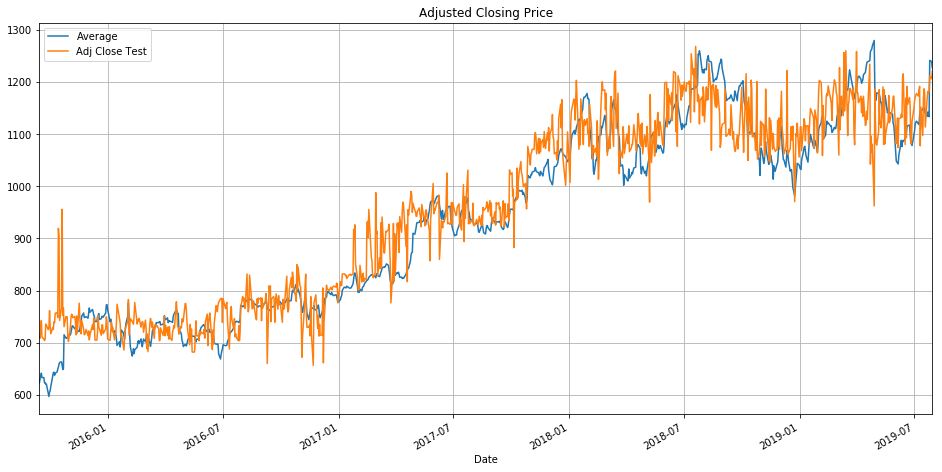

In [188]:
df_cleaned['Adj Close Test'] = y_pred
df_cleaned.drop(columns_drop, axis=1, inplace=True)

df_cleaned.plot(label='GOOG', figsize=(16,8), title='Adjusted Closing Price', grid=True)